# Exploratory Data Analysis

## Problem Statement

- Specific:
  - What precisely do you plan to do?
  - What type of model will you need to develop?
- Measurable:
  - What metrics will you be using to assess performance?
  - MSE? Accuracy? Precision? AUC?
- Achievable:
  - Is your project appropriately scoped?
  - Is it too aggressive?  Too easy?
  - *Note:* If your project is too big, break it up into smaller pieces.  Sometimes a good project is the simply one part of a larger, longer-term agenda.
- Relevant:
  - Does anyone care about this?
  - Why should people be interested in your results?
  - What value will the completion of your project be adding?
- Time-bound
  - What's your deadline?

In this study, we will first perform customer segmentation based on the Q3 datasets we obtained from IBM Business Analytics Community. 

In every company, the quintessential plan is often its retention plan. This study will also extends to predict the customer churn in the next three months from past data. The model accuracy will be assessed as overall prediction performance. The ROC AUC is used for further review the specificity and sensitivity on the model performance. To further apply for market deployment, additional time-series datasets will then verify the churning probability of customers. 

## Introduction

> There is a big difference between a satisfied customer and a loyal customer - Shep Hyken


With spewing yet saturated competitions in the telecommunication industry, in order to stay ahead, customer satisfaction is always a driver with customer attrition as a goal.

Customer Attrition is also known as customer churn where customer ends the commercial relationship with the business. Customer lifetime value (CLTV) an important key metric to measure the health of business. Customer attrition is inevitable, but as business the goal is to reduce customer attrition. Churn rate is expressed as a rate that indicates the number of customers lost over a given period of time. With the cost of acquisition often greater than customer retention [(Customer Retention Strategy, 2016)](https://blog.exitbee.com/8-simple-customer-retention-strategies-to-decrease-your-churn-rate/), being able to identify why and when a customer is leaving, allows business to take on proactive approach and win the customer back. 

## Notebook Brief

The IBM telco churn datasets are used as a part of customer attrition study. The dataset consists of merged files which includes, the demographics, churn status, services subscription, charges and revenue as a Q3 report. 

The datasets is localised in the California state only, with 7043 rows of fictional customer datasets for this study's purpose. 

# Data Import

In [1]:
#import library
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

#for hypothesis testing
from scipy import stats

#for mapping
import geopandas as gpd
from shapely.geometry import Point
import folium 

In [3]:
#read merged dataset
telco = pd.read_csv('../data/telco_churn_data.csv')

#set display max 100
pd.set_option('display.max_columns',100)
pd.set_option('display.max_rows',100)

Upon several iteration, the following columns has been dropped as the entire dataset depict the same singular information.

1. `lat_long` , `country`, `state`,`quarter` and `customer_id`.

Further columns were dropped as the collinearity of the information against existing columns.

2. `partner`, `device_protection_plan`,`premium_tech_support`, `tenure_in_months`

Churn Label is dropped as well as it reflects the customer status. 

3. `churn_label`

Identification of partner has collinearity with married status. Hence were dropped in the earlier stage. 

4. `partner`

In [4]:
#drop lat_long as longitude and latitude col is present
#drop country and states as all data from same location
#drop quarter as all data is in Q3
#drop customer ID 

#drop partner, drop protection plan, drop premium tech support
#drop churn label 
#drop tenure in months

telco = telco.drop(columns=['country','state','lat_long', 'quarter','customer_id', 'partner', 
                            'device_protection_plan','premium_tech_support', 'churn_label', 'tenure_in_months'])

In [5]:
telco.head()

,gender,age,under_30,senior_citizen,married,dependents,number_of_dependents,city,zip_code,latitude,longitude,tenure_months,phone_service,multiple_lines,internet_service,online_security,online_backup,device_protection,tech_support,streaming_tv,streaming_movies,contract,paperless_billing,payment_method,churn_value,churn_score,cltv,churn_reason,referred_a_friend,number_of_referrals,offer,avg_monthly_long_distance_charges,internet_type,avg_monthly_gb_download,streaming_music,unlimited_data,monthly_charge,total_charges_y,total_refunds,total_extra_data_charges,total_long_distance_charges,total_revenue,satisfaction_score,customer_status,churn_category,pop_density
0,Male,78,No,Yes,No,No,0,Los Angeles,90022,34.023810,-118.156582,1,No,No phone service,DSL,No,No,Yes,No,No,Yes,Month-to-month,Yes,Electronic check,1,100,5433,Competitor offered more data,No,0,None,0.00,DSL,8,No,No,39.65,39.65,0.00,20,0.00,59.65,3,Churned,Competitor,15334
1,Female,74,No,Yes,Yes,Yes,1,Los Angeles,90063,34.044271,-118.185237,8,Yes,Yes,Fiber optic,No,Yes,No,No,No,No,Month-to-month,Yes,Credit card (automatic),1,69,5302,Competitor made better offer,Yes,1,Offer E,48.85,Fiber Optic,17,No,Yes,80.65,633.30,0.00,0,390.80,1024.10,3,Churned,Competitor,17038
2,Male,71,No,Yes,No,Yes,3,Los Angeles,90065,34.108833,-118.229715,18,Yes,Yes,Fiber optic,No,No,No,No,Yes,Yes,Month-to-month,Yes,Electronic check,1,81,3179,Competitor made better offer,No,0,Offer D,11.33,Fiber Optic,52,Yes,Yes,95.45,1752.55,45.61,0,203.94,1910.88,2,Churned,Competitor,8625
3,Female,78,No,Yes,Yes,Yes,1,Inglewood,90303,33.936291,-118.332639,25,Yes,No,Fiber optic,No,Yes,Yes,No,Yes,Yes,Month-to-month,Yes,Electronic check,1,88,5337,Limited range of services,Yes,1,Offer C,19.76,Fiber Optic,12,No,Yes,98.50,2514.50,13.43,0,494.00,2995.07,2,Churned,Dissatisfaction,11799
4,Female,80,No,Yes,Yes,Yes,1,Whittier,90602,33.972119,-118.020188,37,Yes,Yes,Fiber optic,No,No,No,No,No,No,Month-to-month,Yes,Electronic check,1,67,2793,Extra data charges,Yes,1,Offer C,6.33,Fiber Optic,14,No,Yes,76.50,2868.15,0.00,0,234.21,3102.36,2,Churned,Price,6947


Columns are updated to binary information for evaluation in numerical rates.

In [6]:
#columns with Yes/No output to udpate to binary 
columns = ['under_30', 'senior_citizen', 'married', 'dependents',
           'phone_service','paperless_billing','referred_a_friend',
           'streaming_music','unlimited_data','online_security','online_backup', 
           'device_protection','tech_support','streaming_tv','streaming_movies','multiple_lines']

#replacement of values
telco[columns] = telco[columns].replace({'No': 0, 'Yes': 1,'No internet service': 0, 'No phone service':0})
telco['gender'] = telco['gender'].replace({'Male': 0,'Female': 1})

#create col for new_user 
telco['new_user'] = (telco['customer_status'] == 'Joined').astype(int)
 
#target value churned  = 1, stayed = 0, joined = 0 
telco['customer_status'] = telco['customer_status'].replace({'Churned': 1,'Stayed': 0, 'Joined':0})

#rename contract to num of months
# telco['contract'] = telco['contract'].replace({'Month-to-month': 1, 'Two year': 24, 'One year':12})


In [7]:
#null in churn cat and churn reason
telco.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 47 columns):
 #   Column                             Non-Null Count  Dtype  
---  ------                             --------------  -----  
 0   gender                             7043 non-null   int64  
 1   age                                7043 non-null   int64  
 2   under_30                           7043 non-null   int64  
 3   senior_citizen                     7043 non-null   int64  
 4   married                            7043 non-null   int64  
 5   dependents                         7043 non-null   int64  
 6   number_of_dependents               7043 non-null   int64  
 7   city                               7043 non-null   object 
 8   zip_code                           7043 non-null   int64  
 9   latitude                           7043 non-null   float64
 10  longitude                          7043 non-null   float64
 11  tenure_months                      7043 non-null   int64

In [8]:
# managing isnull values as N/A for churn_category and churn_reason
telco.churn_reason = telco.churn_reason.fillna('NA')
telco.churn_category = telco.churn_category.fillna('NA')

In [9]:
#minor rename of total charges for consistency
telco = telco.rename(columns={'total_charges_y':'total_charges'})

In [11]:
telco.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 47 columns):
 #   Column                             Non-Null Count  Dtype  
---  ------                             --------------  -----  
 0   gender                             7043 non-null   int64  
 1   age                                7043 non-null   int64  
 2   under_30                           7043 non-null   int64  
 3   senior_citizen                     7043 non-null   int64  
 4   married                            7043 non-null   int64  
 5   dependents                         7043 non-null   int64  
 6   number_of_dependents               7043 non-null   int64  
 7   city                               7043 non-null   object 
 8   zip_code                           7043 non-null   int64  
 9   latitude                           7043 non-null   float64
 10  longitude                          7043 non-null   float64
 11  tenure_months                      7043 non-null   int64

In [12]:
#export regression analysis and clustering
telco.to_csv('../data/telco_final.csv',index=False)

## Numerical Data Exploration

26% of the datasets contains churn customers whereas balance 74% consists of current customers and newly joined customers in Q3. As preliminary exploration, the features that were converted to binary columns are evaluated on the mean against the customer status. 

In [13]:
telco.customer_status.value_counts(normalize=True)

0    0.73463
1    0.26537
Name: customer_status, dtype: float64

In [14]:
#group numerical columns 
num_tel = telco.select_dtypes(include='number')
#group columns by customer status ( 1: Churn or 0: Stayed ) 
num_tel = num_tel.groupby(by='customer_status').agg('mean')
num_tel

,gender,age,under_30,senior_citizen,married,dependents,number_of_dependents,zip_code,latitude,longitude,tenure_months,phone_service,multiple_lines,online_security,online_backup,device_protection,tech_support,streaming_tv,streaming_movies,paperless_billing,churn_value,churn_score,cltv,referred_a_friend,number_of_referrals,avg_monthly_long_distance_charges,avg_monthly_gb_download,streaming_music,unlimited_data,monthly_charge,total_charges,total_refunds,total_extra_data_charges,total_long_distance_charges,total_revenue,satisfaction_score,pop_density,new_user
customer_status,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
0,0.492656,45.344414,0.212022,0.128721,0.528218,0.293970,0.595284,93518.212215,36.287436,-119.804838,37.569965,0.901044,0.409934,0.333204,0.368380,0.362775,0.335137,0.365868,0.369927,0.535562,0.0,50.098183,4490.921337,0.502126,2.468690,22.883572,19.915733,0.340162,0.626788,61.265124,2550.792103,2.122279,6.752996,862.952107,3418.374927,3.789911,3506.372826,0.087746
1,0.502408,49.735688,0.162654,0.254682,0.357945,0.056715,0.118245,93532.352595,36.268614,-119.782388,17.979133,0.909042,0.454789,0.157838,0.279829,0.291600,0.165864,0.435527,0.437667,0.749064,1.0,82.510433,4149.414660,0.333868,0.521134,23.167635,22.175495,0.389513,0.803638,74.441332,1531.796094,1.518983,7.158909,433.917549,1971.353569,1.736223,3690.815944,0.000000


### Binary Features

In [15]:
#columns with binary features

less_one = ['gender', 'under_30', 'senior_citizen', 'married', 'dependents',
       'number_of_dependents', 'phone_service', 'multiple_lines', 'online_security',
       'online_backup', 'device_protection', 'tech_support', 'streaming_tv',
       'streaming_movies', 'paperless_billing', 'referred_a_friend', 'streaming_music',
       'unlimited_data']

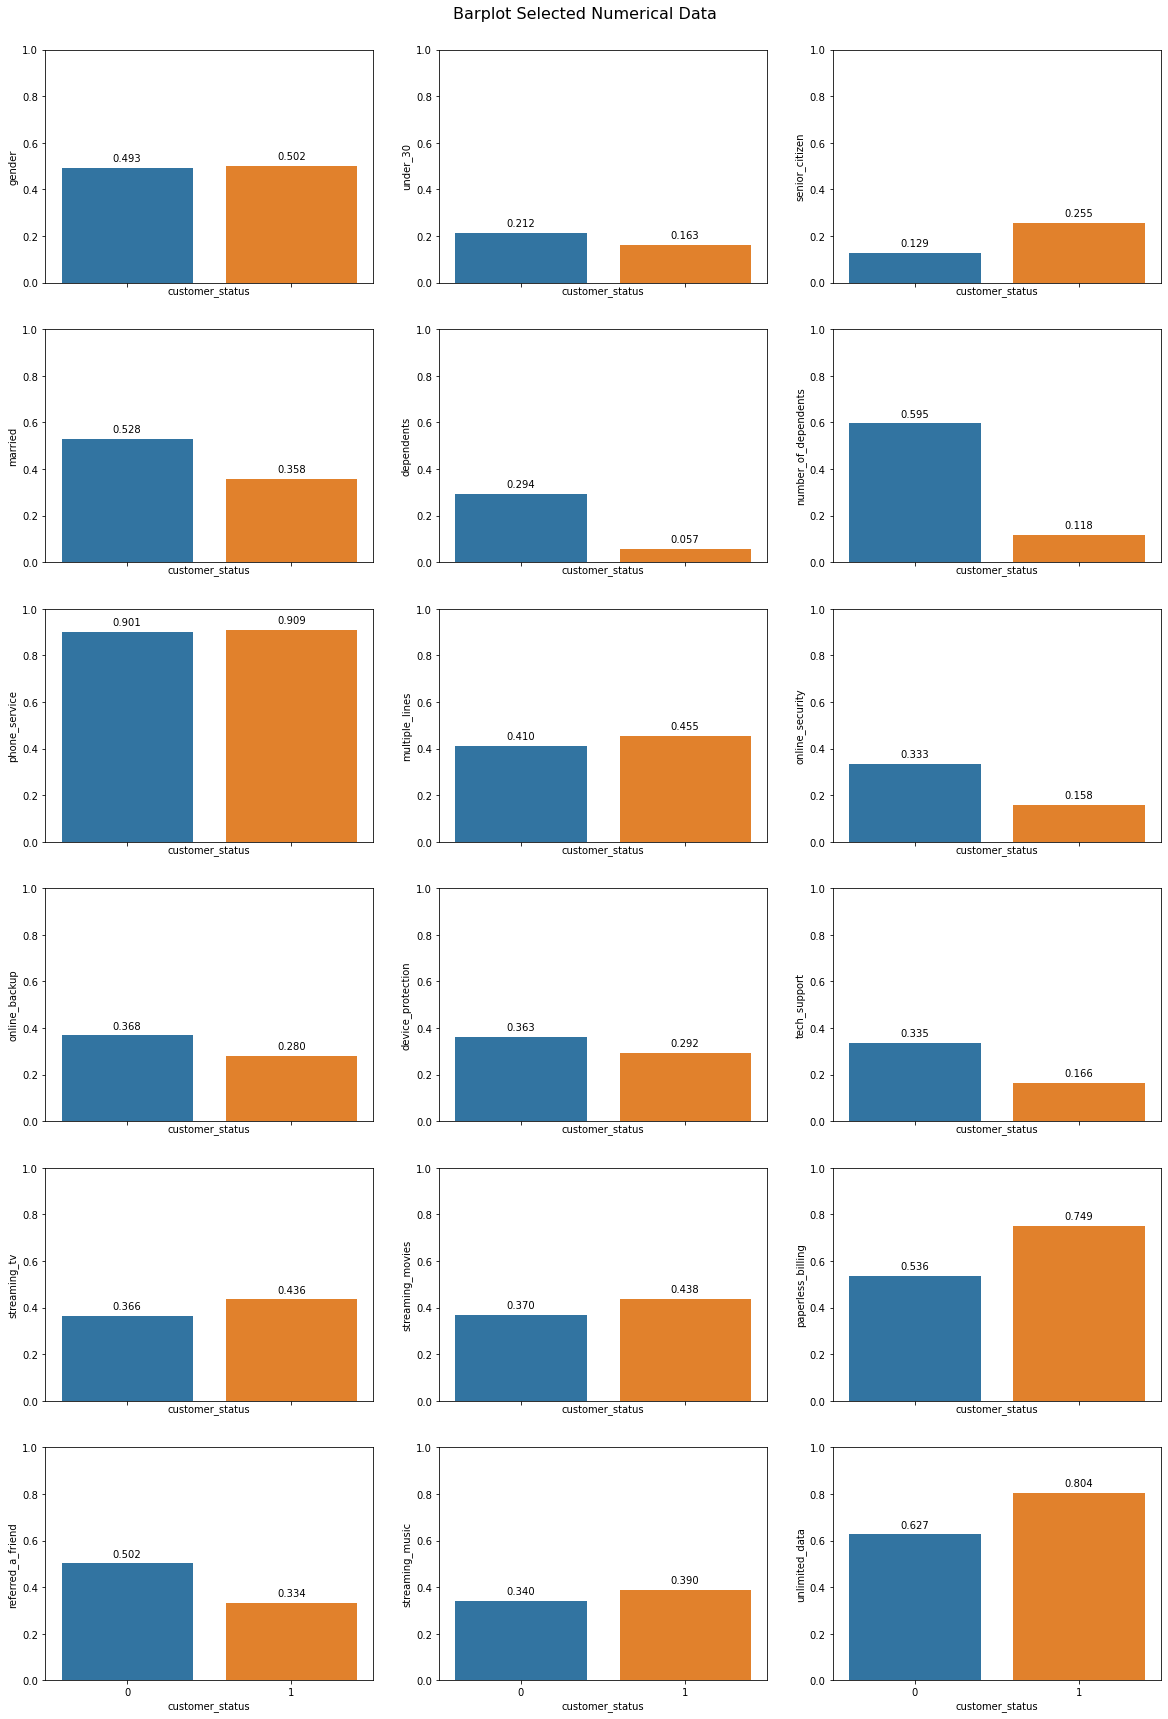

In [16]:
fig, ax = plt.subplots(nrows=6, ncols=3, figsize=(20,30), sharex=True)
ax = ax.flatten()

for idx, col in enumerate(less_one):
    graph = sns.barplot(data=num_tel, x=num_tel.index, y=col, ax=ax[idx],)
    ax[idx].set_ylim(ymin=0.0, ymax=1.0)
    
#annotation
    for p in graph.patches:
        graph.annotate('{:.3f}'.format(p.get_height()), (p.get_x()+0.4, p.get_height()+0.02),
                    ha='center', va='bottom',
                   color= 'black')
        
plt.suptitle(t='Barplot Selected Numerical Data',x=0.5, y = .9, fontsize=16);
# plt.savefig('../images/barplot_numerical')
plt.show()

*Interpretation:*

1. Several features does not indicate a strong seperation for instance, `gender`, `under_30`, `phone_service`, `device_protection`, `streaming_movies` and `multiple_lines`.


### Age Groups

Age groups consist of 19 - 29, 30 - 64, 65 - 80. 
Distribution 64% between 30-64 and 16%  and 20% for senior citizen and under 30 respectively.

In [105]:
age_group = telco.groupby(by=['under_30','senior_citizen']).agg(['mean', lambda x : x.count()/telco.shape[0]])['age'].rename(columns={'mean':'age_mean','<lambda_0>':'perc_age'})
age_group.reset_index()

,under_30,senior_citizen,age_mean,perc_age
0,0,0,46.963778,0.638932
1,0,1,72.457093,0.162147
2,1,0,23.900785,0.198921


## Categorical Data Exploration

Assumption on linear relationship between features

In [17]:
#group categorical columns 
cat_tel = telco.select_dtypes(exclude='number')
#group columns by customer status ( 1: Churn or 0: Stayed ) 
#drop churn statuses and city
cat_tel = cat_tel.drop(columns=['churn_reason','churn_category', 'city'])

In [18]:
#merge bool and cat together
cat_tel = pd.concat([cat_tel,telco[less_one], telco['customer_status']], axis=1)

In [19]:
cat_tel.head()

,internet_service,contract,payment_method,offer,internet_type,gender,under_30,senior_citizen,married,dependents,number_of_dependents,phone_service,multiple_lines,online_security,online_backup,device_protection,tech_support,streaming_tv,streaming_movies,paperless_billing,referred_a_friend,streaming_music,unlimited_data,customer_status
0,DSL,Month-to-month,Electronic check,None,DSL,0,0,1,0,0,0,0,0,0,0,1,0,0,1,1,0,0,0,1
1,Fiber optic,Month-to-month,Credit card (automatic),Offer E,Fiber Optic,1,0,1,1,1,1,1,1,0,1,0,0,0,0,1,1,0,1,1
2,Fiber optic,Month-to-month,Electronic check,Offer D,Fiber Optic,0,0,1,0,1,3,1,1,0,0,0,0,1,1,1,0,1,1,1
3,Fiber optic,Month-to-month,Electronic check,Offer C,Fiber Optic,1,0,1,1,1,1,1,0,0,1,1,0,1,1,1,1,0,1,1
4,Fiber optic,Month-to-month,Electronic check,Offer C,Fiber Optic,1,0,1,1,1,1,1,1,0,0,0,0,0,0,1,1,0,1,1


### Pearsons Chi Squared Test 

Cramér’s V is a number between 0 and 1 that indicates how strongly two categorical variables are associated.

getting Cramer V  value from chi squared test. 

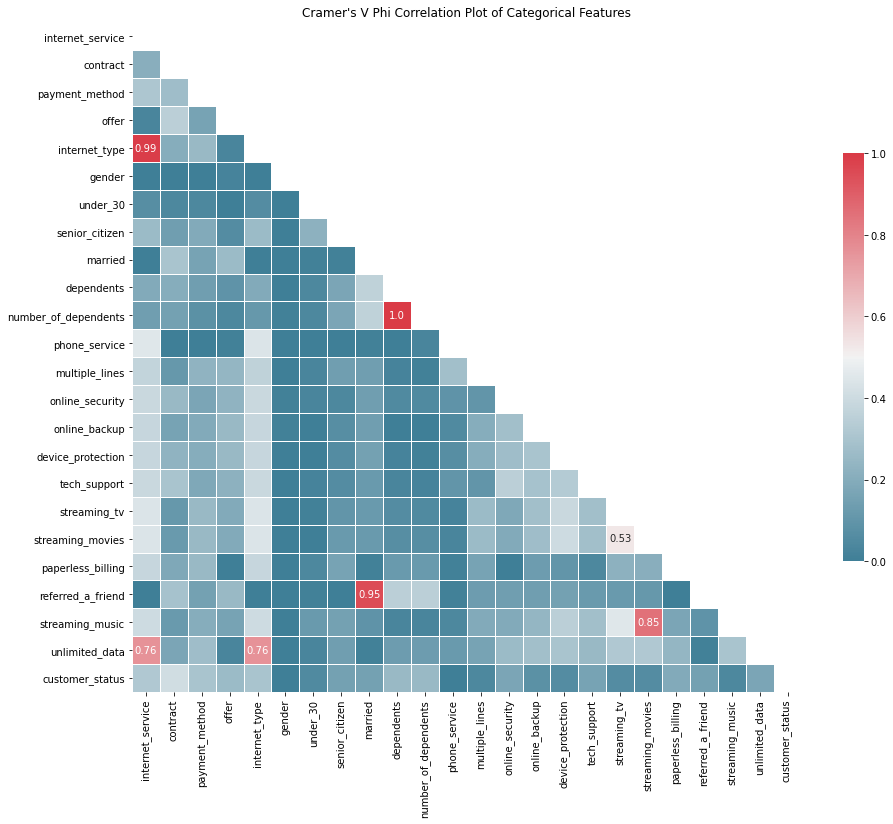

In [20]:
#cramers formula : using chi2 to measure strength of relationship
def cramers_v(x, y):
    #create cross tab
    confusion_matrix = pd.crosstab(x,y)
    chi2 = stats.chi2_contingency(confusion_matrix)[0] #chi2
    n = confusion_matrix.sum().sum()
    phi2 = chi2/n
    r,k = confusion_matrix.shape
    phi2corr = max(0, phi2-((k-1)*(r-1))/(n-1))
    rcorr = r-((r-1)**2)/(n-1)
    kcorr = k-((k-1)**2)/(n-1)
    return np.sqrt(phi2corr/min((kcorr-1),(rcorr-1)))


# Create a correlation dataframe
corrs = dict()
categorical = cat_tel
for out_col in categorical.columns:
    col_corr = dict()
    for in_col in categorical.columns:
        col_corr[in_col] = cramers_v(categorical[in_col], categorical[out_col])
    corrs[out_col] = col_corr
corrs = pd.DataFrame(corrs)
# Plotting correlation heatmap 
corr = round(corrs, 2)
plt.figure(figsize=(15,15))
cmap = sns.diverging_palette(225,10,as_cmap=True)
mask = np.triu(np.ones_like(corr, dtype= bool))
labels = corr.applymap(lambda v: v if (v > 0.45) else '')

sns.heatmap(corr, square=True, annot=labels, mask=mask, cmap=cmap, 
            linewidths=.5, cbar_kws={'shrink':0.5}, fmt='.2', vmin=0, vmax=1)
plt.title("Cramer's V Phi Correlation Plot of Categorical Features")
plt.show()

Not significance testing but correlation coefficient between categorical features

1. Internet type vs internet service
2. Relationship with married and referred a friend. 
3. unlimited data, internet service - internet type
4. dependents, num dependents
5. streaming_movies, streaming music

In [21]:
pd.crosstab(index=telco.internet_service,columns=telco.internet_type)

internet_type,Cable,DSL,Fiber Optic,None
internet_service,,,,
DSL,769,1652,0,0
Fiber optic,61,0,3035,0
No,0,0,0,1526


internet_service instead of internet_type

In [22]:
#married that has referred a friend 
telco[telco.married==True].referred_a_friend.value_counts(normalize=True)

1    0.94709
0    0.05291
Name: referred_a_friend, dtype: float64

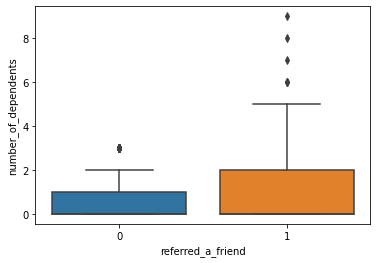

In [23]:
#married customer that referred 'friend'
sns.boxplot(data=telco[telco.married==True], x='referred_a_friend', y='number_of_dependents')
plt.show()

95% married partner made a reference. The hypothesis that that married partner are the refered friend. 

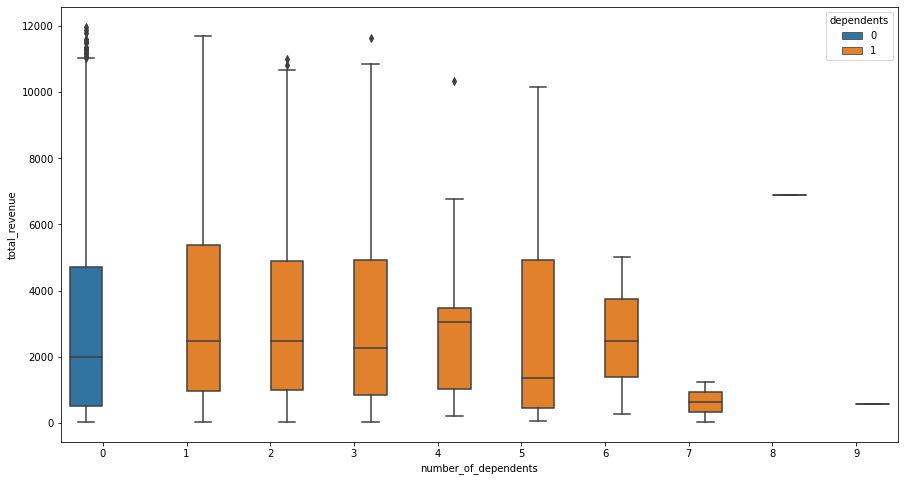

In [24]:
#dependents with num  on the revenue
plt.figure(figsize=(15,8))
sns.boxplot(data=telco, x='number_of_dependents', y='total_revenue', hue='dependents')
plt.show()

In [25]:
telco[telco.dependents==False]['number_of_dependents'].value_counts()

0    5416
Name: number_of_dependents, dtype: int64

In [26]:
pd.crosstab(index=telco.internet_service,columns=telco.unlimited_data)

unlimited_data,0,1
internet_service,,
DSL,343,2078
Fiber optic,429,2667
No,1526,0


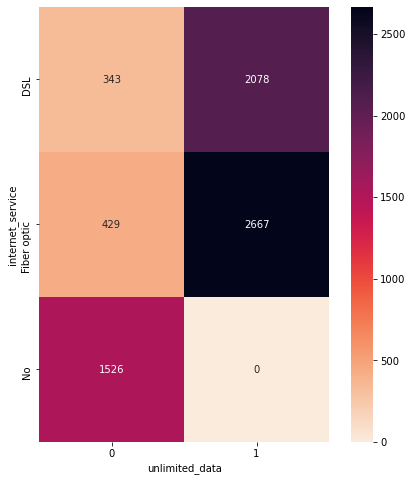

In [27]:
plt.figure(figsize=(8,8))
sns.heatmap(data=pd.crosstab(index=telco.internet_service,columns=telco.unlimited_data), square=True, 
           annot=True, fmt='d', cmap=sns.cm.rocket_r)
plt.show()

In [28]:
pd.crosstab(index=telco.streaming_music,columns=telco.streaming_movies)

streaming_movies,0,1
streaming_music,,
0,4180,375
1,131,2357


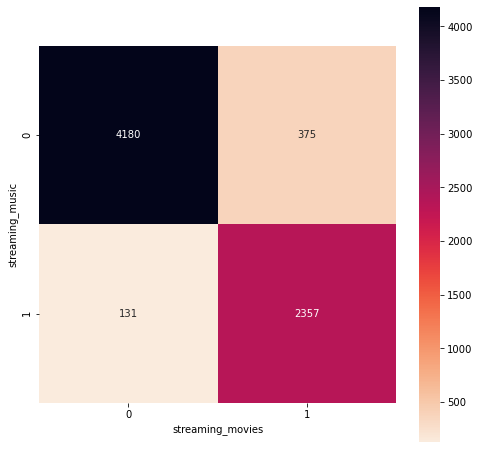

In [29]:
plt.figure(figsize=(8,8))
sns.heatmap(data=pd.crosstab(index=telco.streaming_music,columns=telco.streaming_movies), square=True, 
           annot=True, fmt='d', cmap=sns.cm.rocket_r)
plt.show()

COLLINEAR 

## Continous Data Exploration

In [30]:
#numerical cols larger than 1.0
more_one = num_tel.columns[~num_tel.columns.isin(less_one)]
more_one = more_one.drop(['zip_code','latitude', 'longitude', 'churn_value','new_user'])

In [31]:
more_one

Index(['age', 'tenure_months', 'churn_score', 'cltv', 'number_of_referrals',
       'avg_monthly_long_distance_charges', 'avg_monthly_gb_download',
       'monthly_charge', 'total_charges', 'total_refunds',
       'total_extra_data_charges', 'total_long_distance_charges',
       'total_revenue', 'satisfaction_score', 'pop_density'],
      dtype='object')

In [32]:
telco[more_one]

,age,tenure_months,churn_score,cltv,number_of_referrals,avg_monthly_long_distance_charges,avg_monthly_gb_download,monthly_charge,total_charges,total_refunds,total_extra_data_charges,total_long_distance_charges,total_revenue,satisfaction_score,pop_density
0,78,1,100,5433,0,0.00,8,39.65,39.65,0.00,20,0.00,59.65,3,15334
1,74,8,69,5302,1,48.85,17,80.65,633.30,0.00,0,390.80,1024.10,3,17038
2,71,18,81,3179,0,11.33,52,95.45,1752.55,45.61,0,203.94,1910.88,2,8625
3,78,25,88,5337,1,19.76,12,98.50,2514.50,13.43,0,494.00,2995.07,2,11799
4,80,37,67,2793,1,6.33,14,76.50,2868.15,0.00,0,234.21,3102.36,2,6947
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7038,30,72,45,5306,0,22.77,0,21.15,1419.40,19.31,0,1639.44,3039.53,5,15
7039,38,24,59,2140,1,36.05,24,84.80,1990.50,48.23,0,865.20,2807.47,3,192
7040,30,72,71,5560,4,29.66,59,103.20,7362.90,45.38,0,2135.52,9453.04,4,0
7041,32,11,59,2793,1,0.00,17,29.60,346.45,27.24,0,0.00,319.21,4,5


### Pearsonr Test

Significance of the coefficient correlation. 

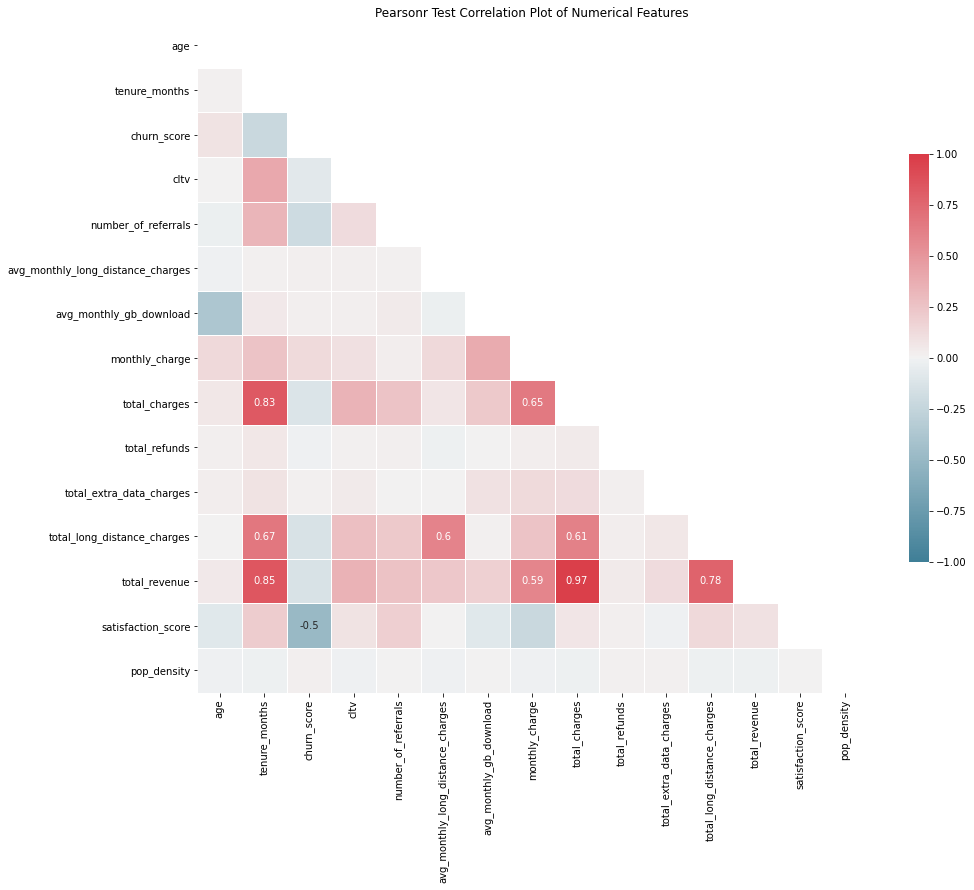

In [33]:
# Plotting correlation heatmap 
corr = round(telco[more_one].corr(), 2)
plt.figure(figsize=(15,15))
labels = corr.applymap(lambda v: v if (v > 0.45) | (v < -0.45) else '')
cmap = sns.diverging_palette(225,10,as_cmap=True)
mask = np.triu(np.ones_like(corr, dtype= bool))

sns.heatmap(corr, square=True, annot=labels, mask=mask, cmap=cmap, 
            linewidths=.5, cbar_kws={'shrink':0.5}, fmt='.2', vmin=-1, vmax=1)

plt.title('Pearsonr Test Correlation Plot of Numerical Features')
plt.show()

highly correlated tenure_in_months, and tenure_months, total_charges, and total_revenue
drop pop density

In [55]:
more_one.p

Index(['age', 'tenure_months', 'churn_score', 'cltv', 'number_of_referrals',
       'avg_monthly_long_distance_charges', 'avg_monthly_gb_download',
       'monthly_charge', 'total_charges', 'total_refunds',
       'total_extra_data_charges', 'total_long_distance_charges',
       'total_revenue', 'satisfaction_score', 'pop_density'],
      dtype='object')

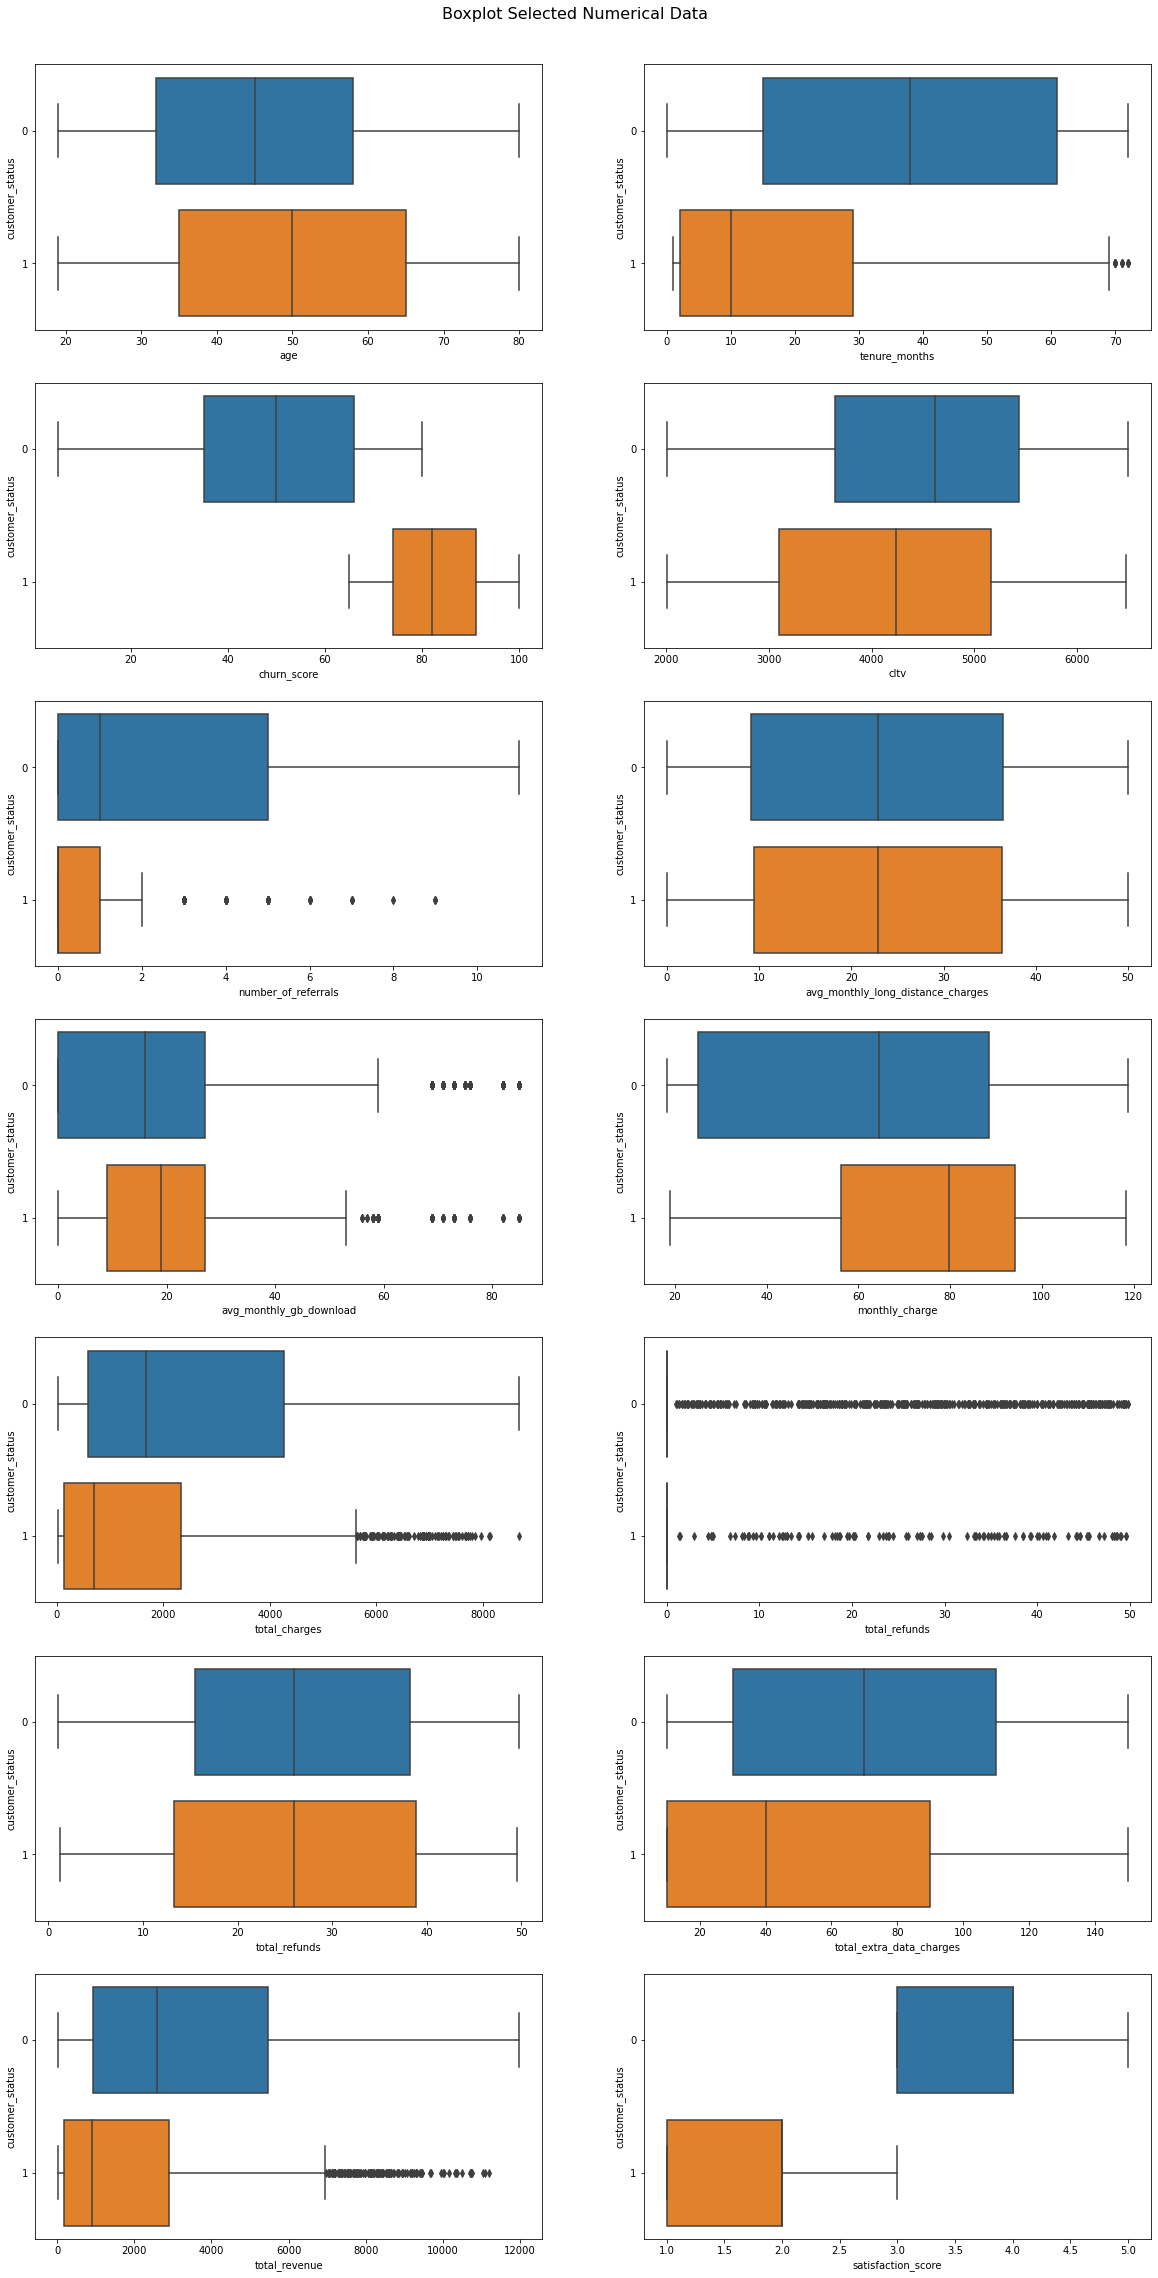

In [56]:
fig, ax = plt.subplots(nrows=7, ncols=2, figsize=(20,40))
ax = ax.flatten()

for idx, col in enumerate(more_one):
    if idx == 14:
        pass
    #for refund col removing 0
    elif idx == 10:
        sns.boxplot(data=telco[telco['total_refunds']>0], x='total_refunds', y='customer_status', 
                    orient='h', ax=ax[10])
        
    #for extra data charges col removing 0
    elif idx == 11:
        sns.boxplot(data=telco[telco['total_extra_data_charges']>0], x='total_extra_data_charges', 
                    y='customer_status', orient='h', ax=ax[11])
    else:
        sns.boxplot(data=telco, y=telco.customer_status, x=col, ax=ax[idx], orient='h')

plt.suptitle(t='Boxplot Selected Numerical Data',x=0.5, y = .9, fontsize=16);
# plt.savefig('../images/boxplot_numerical')
plt.show()

tenure months  and device protection the same 

### Other EDA

In [57]:
telco.head()

,gender,age,under_30,senior_citizen,married,dependents,number_of_dependents,city,zip_code,latitude,longitude,tenure_months,phone_service,multiple_lines,internet_service,online_security,online_backup,device_protection,tech_support,streaming_tv,streaming_movies,contract,paperless_billing,payment_method,churn_value,churn_score,cltv,churn_reason,referred_a_friend,number_of_referrals,offer,avg_monthly_long_distance_charges,internet_type,avg_monthly_gb_download,streaming_music,unlimited_data,monthly_charge,total_charges,total_refunds,total_extra_data_charges,total_long_distance_charges,total_revenue,satisfaction_score,customer_status,churn_category,pop_density,new_user,geometry
0,0,78,0,1,0,0,0,Los Angeles,90022,34.023810,-118.156582,1,0,0,DSL,0,0,1,0,0,1,Month-to-month,1,Electronic check,1,100,5433,Competitor offered more data,0,0,None,0.00,DSL,8,0,0,39.65,39.65,0.00,20,0.00,59.65,3,1,Competitor,15334,0,POINT (-118.15658 34.02381)
1,1,74,0,1,1,1,1,Los Angeles,90063,34.044271,-118.185237,8,1,1,Fiber optic,0,1,0,0,0,0,Month-to-month,1,Credit card (automatic),1,69,5302,Competitor made better offer,1,1,Offer E,48.85,Fiber Optic,17,0,1,80.65,633.30,0.00,0,390.80,1024.10,3,1,Competitor,17038,0,POINT (-118.18524 34.04427)
2,0,71,0,1,0,1,3,Los Angeles,90065,34.108833,-118.229715,18,1,1,Fiber optic,0,0,0,0,1,1,Month-to-month,1,Electronic check,1,81,3179,Competitor made better offer,0,0,Offer D,11.33,Fiber Optic,52,1,1,95.45,1752.55,45.61,0,203.94,1910.88,2,1,Competitor,8625,0,POINT (-118.22971 34.10883)
3,1,78,0,1,1,1,1,Inglewood,90303,33.936291,-118.332639,25,1,0,Fiber optic,0,1,1,0,1,1,Month-to-month,1,Electronic check,1,88,5337,Limited range of services,1,1,Offer C,19.76,Fiber Optic,12,0,1,98.50,2514.50,13.43,0,494.00,2995.07,2,1,Dissatisfaction,11799,0,POINT (-118.33264 33.93629)
4,1,80,0,1,1,1,1,Whittier,90602,33.972119,-118.020188,37,1,1,Fiber optic,0,0,0,0,0,0,Month-to-month,1,Electronic check,1,67,2793,Extra data charges,1,1,Offer C,6.33,Fiber Optic,14,0,1,76.50,2868.15,0.00,0,234.21,3102.36,2,1,Price,6947,0,POINT (-118.02019 33.97212)


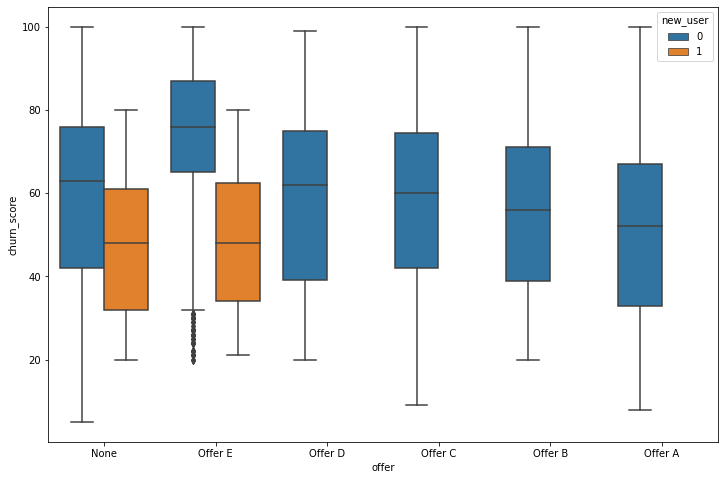

In [58]:
#churn rate on new user based on offer made
plt.figure(figsize=(12,8))
sns.boxplot(data=telco, x='offer', y='churn_score',hue='new_user')
plt.show()

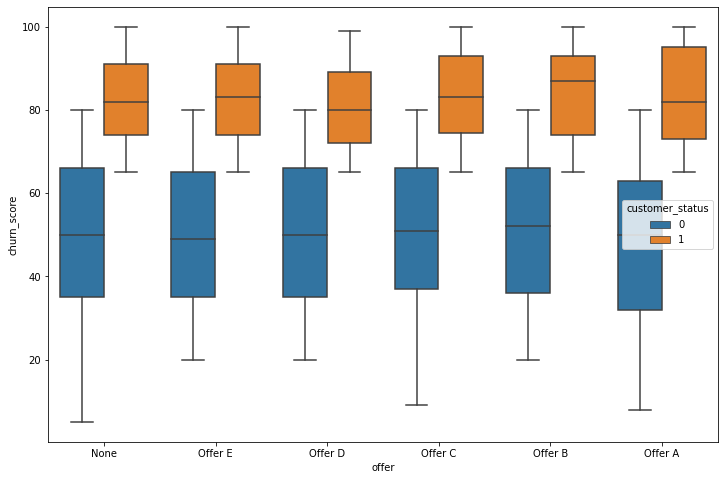

In [64]:
#churn rate on new user based on offer made
plt.figure(figsize=(12,8))
sns.boxplot(data=telco, x='offer', y='churn_score',hue='customer_status')
plt.show()

## Internet Service and Type

In [59]:
telco.internet_type.value_counts(normalize=True)

Fiber Optic    0.430924
DSL            0.234559
None           0.216669
Cable          0.117848
Name: internet_type, dtype: float64

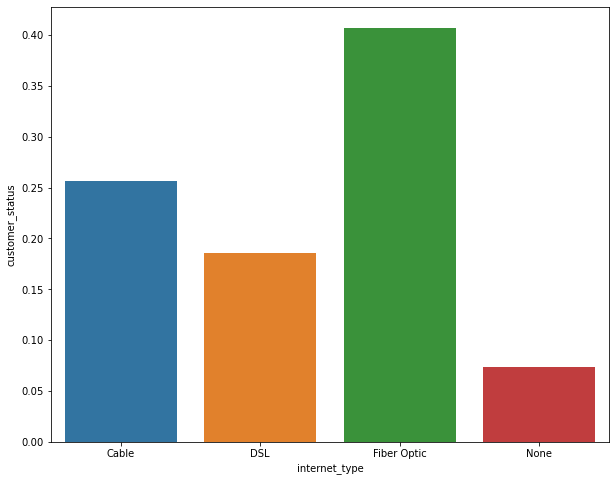

In [60]:
#by churn rate against internet type
plt.figure(figsize=(10,8))
sns.barplot(data=telco.groupby('internet_type').mean()['customer_status'].reset_index(),
            x='internet_type', y='customer_status')
plt.show()

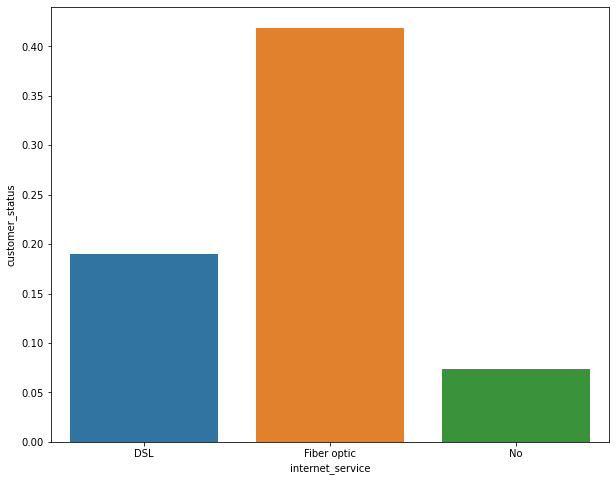

In [61]:
#by churn rate against internet service
plt.figure(figsize=(10,8))
sns.barplot(data=telco.groupby('internet_service').mean()['customer_status'].reset_index(),
            x='internet_service', y='customer_status')
plt.show()

## Contract

<AxesSubplot:xlabel='contract', ylabel='churn_score'>

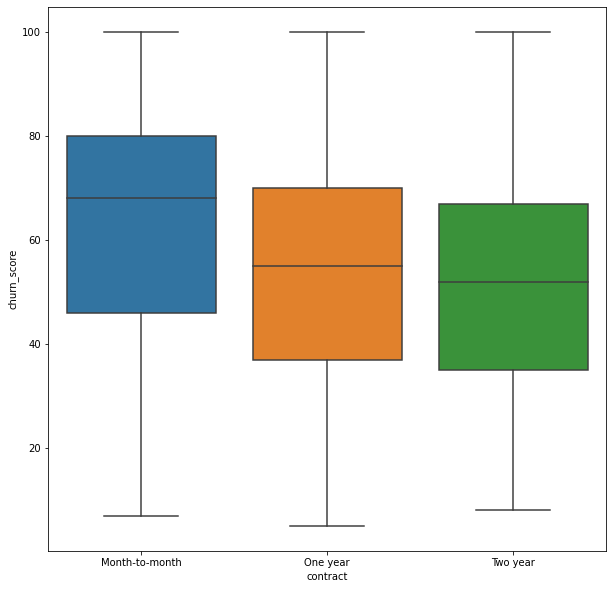

In [69]:
plt.figure(figsize=(10,10))
sns.boxplot(data=telco, x='contract', y='churn_score')

## City

In [63]:
telco.head()

,gender,age,under_30,senior_citizen,married,dependents,number_of_dependents,city,zip_code,latitude,longitude,tenure_months,phone_service,multiple_lines,internet_service,online_security,online_backup,device_protection,tech_support,streaming_tv,streaming_movies,contract,paperless_billing,payment_method,churn_value,churn_score,cltv,churn_reason,referred_a_friend,number_of_referrals,offer,avg_monthly_long_distance_charges,internet_type,avg_monthly_gb_download,streaming_music,unlimited_data,monthly_charge,total_charges,total_refunds,total_extra_data_charges,total_long_distance_charges,total_revenue,satisfaction_score,customer_status,churn_category,pop_density,new_user,geometry
0,0,78,0,1,0,0,0,Los Angeles,90022,34.023810,-118.156582,1,0,0,DSL,0,0,1,0,0,1,Month-to-month,1,Electronic check,1,100,5433,Competitor offered more data,0,0,None,0.00,DSL,8,0,0,39.65,39.65,0.00,20,0.00,59.65,3,1,Competitor,15334,0,POINT (-118.15658 34.02381)
1,1,74,0,1,1,1,1,Los Angeles,90063,34.044271,-118.185237,8,1,1,Fiber optic,0,1,0,0,0,0,Month-to-month,1,Credit card (automatic),1,69,5302,Competitor made better offer,1,1,Offer E,48.85,Fiber Optic,17,0,1,80.65,633.30,0.00,0,390.80,1024.10,3,1,Competitor,17038,0,POINT (-118.18524 34.04427)
2,0,71,0,1,0,1,3,Los Angeles,90065,34.108833,-118.229715,18,1,1,Fiber optic,0,0,0,0,1,1,Month-to-month,1,Electronic check,1,81,3179,Competitor made better offer,0,0,Offer D,11.33,Fiber Optic,52,1,1,95.45,1752.55,45.61,0,203.94,1910.88,2,1,Competitor,8625,0,POINT (-118.22971 34.10883)
3,1,78,0,1,1,1,1,Inglewood,90303,33.936291,-118.332639,25,1,0,Fiber optic,0,1,1,0,1,1,Month-to-month,1,Electronic check,1,88,5337,Limited range of services,1,1,Offer C,19.76,Fiber Optic,12,0,1,98.50,2514.50,13.43,0,494.00,2995.07,2,1,Dissatisfaction,11799,0,POINT (-118.33264 33.93629)
4,1,80,0,1,1,1,1,Whittier,90602,33.972119,-118.020188,37,1,1,Fiber optic,0,0,0,0,0,0,Month-to-month,1,Electronic check,1,67,2793,Extra data charges,1,1,Offer C,6.33,Fiber Optic,14,0,1,76.50,2868.15,0.00,0,234.21,3102.36,2,1,Price,6947,0,POINT (-118.02019 33.97212)


In [42]:
filename = '../data/county_ca/county_ca.geojson'
file = open(filename)

ca_map = gpd.read_file(file)

In [43]:
#create geodf for city
geometry_city = [Point(xy) for xy in zip(telco['longitude'], telco['latitude'])]
geo_df = gpd.GeoDataFrame(telco,crs="epsg:4326", geometry = geometry_city)

geo_df = geo_df[['geometry','pop_density','customer_status','latitude','longitude']]

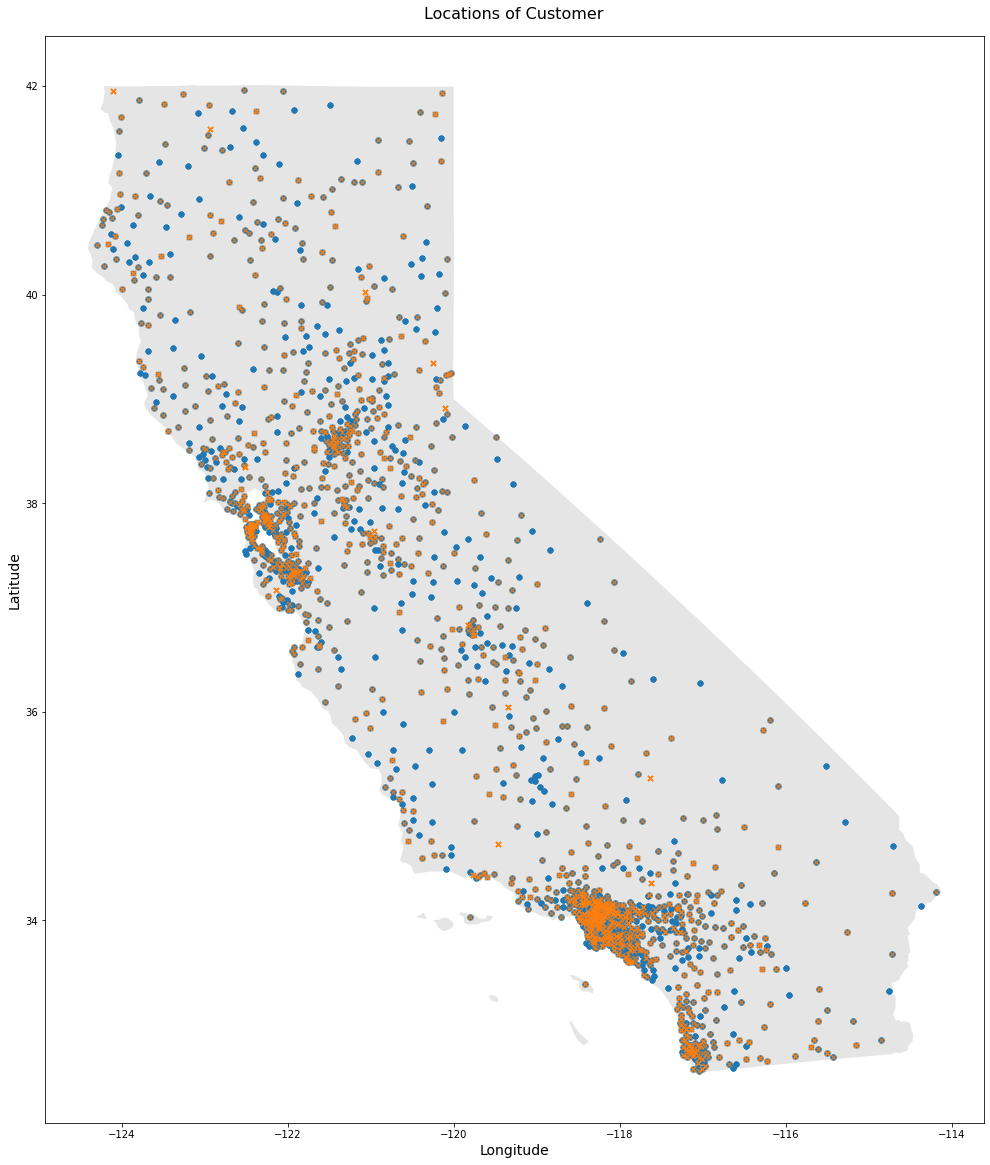

In [44]:
##Plot map of customer location 
fig, ax = plt.subplots(figsize=(20,20))
ca_map.plot(ax=ax, color='tab:grey', alpha=0.2)

geo_df[geo_df.customer_status==0].plot(ax=ax, markersize=25, color='tab:blue', marker='o', alpha=0.7)
geo_df[geo_df.customer_status==1].plot(ax=ax, markersize=25, color='tab:orange', marker='x', alpha=0.7)

plt.title('Locations of Customer', fontsize=16, y=1.01)
plt.xlabel('Longitude', fontsize=14)
plt.ylabel('Latitude', fontsize=14)
plt.show()

### Folium

In [45]:
# Functions to label each row with their respective neighbourhood name
def get_county(row):
    for boundary, county, in zip(ca_map.geometry, ca_map.NAME):
        coor = Point(row['longitude'], row['latitude'])
        if coor.within(boundary):
            return county
    return 'Others'

In [46]:
#apply func to create county col
geo_df['county'] = geo_df.apply(get_county, axis=1)

In [47]:
#groupby to get customer churn rate
county_df = geo_df.groupby(by='county').mean().reset_index()

In [48]:
ca_map['lat'] = ca_map.geometry.centroid.y.astype(float)
ca_map['long'] = ca_map.geometry.centroid.x.astype(float)

<ipython-input-48-a6b4c9437e5f>:1: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  ca_map['lat'] = ca_map.geometry.centroid.y.astype(float)
<ipython-input-48-a6b4c9437e5f>:2: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  ca_map['long'] = ca_map.geometry.centroid.x.astype(float)


In [49]:
m = folium.Map(location=[36, -119], zoom_start=7, tiles='Stamen Terrain', max_zoom=7, min_zoom=6)
bins=list(county_df["customer_status"].quantile([0, 0.25, 0.5, 0.75, 1]))

folium.Choropleth(
    geo_data=ca_map,
    name="ChurnRate",
    data=county_df,
    columns=['county',"customer_status"],
    key_on='feature.properties.NAME',
    fill_color="YlGn",
    fill_opacity=0.7,
    line_opacity=0.2,
    legend_name="Customer Churn Rate",
    bins=bins,
    reset=True,
).add_to(m)

county_fg = folium.FeatureGroup(name='County Names', show=True)

for name, lat, lon in zip(ca_map['NAME'], ca_map['lat'], ca_map['long']):
    label = folium.Popup(name, parse_html=True, max_width=450)
    folium.Marker(
        [lat, lon],
        icon=folium.DivIcon(icon_size=(50,12),
                     html='<div style="font-size: 8pt">%s</div>' % name),
        popup=label).add_to(county_fg)

m.add_child(county_fg)
folium.LayerControl(collapsed=True).add_to(m)

m

## Churn Reason

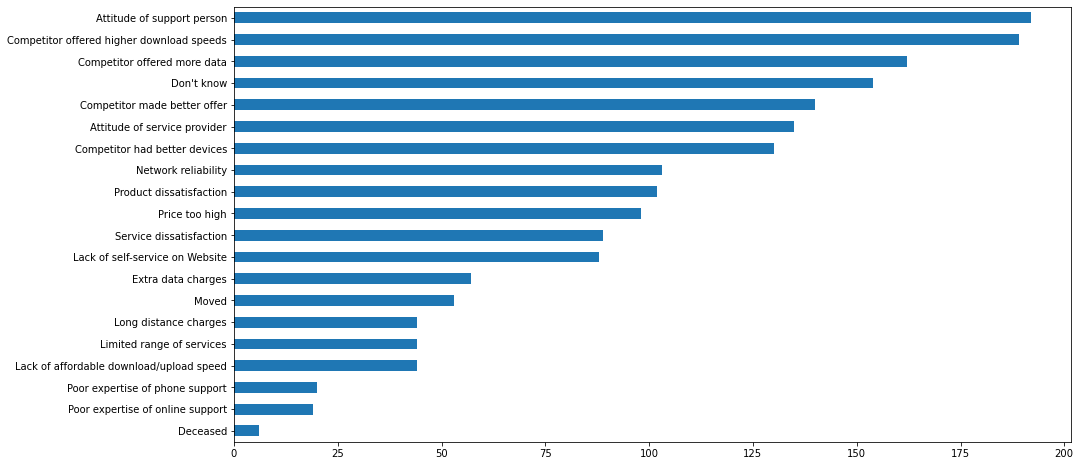

In [120]:
#churned senior citizen
plt.figure(figsize=(15,8))
telco[(telco.customer_status == 1)]['churn_reason'].value_counts(ascending=True).plot(kind='barh')
plt.show()

In [52]:
telco[(telco.customer_status == 1) & (telco.paperless_billing == 1)]['churn_reason'].value_counts()

Competitor offered higher download speeds    144
Attitude of support person                   142
Competitor offered more data                 124
Don't know                                   114
Competitor made better offer                 105
Attitude of service provider                 103
Competitor had better devices                 95
Network reliability                           75
Product dissatisfaction                       74
Price too high                                73
Service dissatisfaction                       71
Lack of self-service on Website               70
Extra data charges                            43
Lack of affordable download/upload speed      35
Moved                                         34
Limited range of services                     33
Long distance charges                         29
Poor expertise of phone support               16
Poor expertise of online support              16
Deceased                                       4
Name: churn_reason, 

In [53]:
telco[(telco.customer_status == 1)]['zip_code'].value_counts()

90020    5
95567    4
93272    4
95367    4
91744    4
        ..
95632    1
95316    1
96103    1
91104    1
90061    1
Name: zip_code, Length: 1190, dtype: int64

In [125]:
cat_df = telco.select_dtypes(exclude='number')

In [ ]:
cat_df.head()

In [130]:
cat_df.groupby('contract').agg([pd.Series.mode])['city','internet_service','payment_method','churn_reason','offer']

/Users/jean/miniconda3/lib/python3.8/site-packages/pandas/core/algorithms.py:944: UserWarning: Unable to sort modes: '<' not supported between instances of 'Point' and 'Point'
  warn(f"Unable to sort modes: {err}")


KeyError: 'Key length (5) exceeds index depth (2)'